In [73]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
import openmeteo_requests
import requests_cache
import time
from retry_requests import retry
from itertools import cycle
import seaborn as sns
import os
%matplotlib inline
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", 120)  

In [74]:
DATA_DIR = Path("data")
BLACKOUT_CSV = DATA_DIR / "2025_10_14_elektro_boiovi_dii_oblasti_osr.csv"
os.makedirs(DATA_DIR, exist_ok=True)
# Дані про відключення електроенергії по регіонах
blackout_df = pd.read_csv(BLACKOUT_CSV, parse_dates=['date'])
blackout_df.head()

,date,number_days,region,number_blackout_consumers,number_blackout_settlements,number_restored_consumers,number_restored_settlements,notes,link
0,2022-02-24,1.0,Донецька,NaN,43.0,NaN,NaN,NaN,https://www.dtek-dem.com.ua/ua/news/2-rayoni-m...
1,2022-02-25,1.0,Луганська,36136.0,NaN,NaN,NaN,NaN,https://www.facebook.com/tovleo/posts/pfbid021...
2,2022-02-26,1.0,Київська,NaN,30.0,NaN,NaN,NaN,https://www.dtek-krem.com.ua/ua/news/vidnovlen...
3,2022-02-26,1.0,Луганська,20114.0,24.0,NaN,NaN,NaN,https://www.facebook.com/tovleo/posts/pfbid02w...
4,2022-02-27,1.0,Луганська,NaN,NaN,2300.0,NaN,NaN,https://www.facebook.com/tovleo/posts/pfbid0Av...


In [75]:
CANONICAL_REGIONS = [
    "Вінницька", "Волинська", "Дніпропетровська", "Донецька",
    "Житомирська", "Закарпатська", "Запорізька",
    "Івано-Франківська", "Київська", "Кіровоградська",
    "Луганська", "Львівська", "Миколаївська", "Одеська",
    "Полтавська", "Рівненська", "Сумська", "Тернопільська",
    "Харківська", "Херсонська", "Хмельницька", "Черкаська",
    "Чернівецька", "Чернігівська",
    "Київ", "м. Севастополь", "АР Крим"
]

REGION_COORDS = {
    "Вінницька": (49.233, 28.467),
    "Волинська": (50.733, 25.317),
    "Дніпропетровська": (48.467, 35.033),
    "Донецька": (48.000, 37.800),
    "Житомирська": (50.250, 28.650),
    "Закарпатська": (48.617, 22.283),
    "Запорізька": (47.833, 35.133),
    "Івано-Франківська": (48.917, 24.700),
    "Київська": (50.450, 30.517),
    "Київ": (50.450, 30.517),
    "Кіровоградська": (48.500, 32.267),
    "Луганська": (48.567, 39.300),
    "Львівська": (49.833, 24.017),
    "Миколаївська": (46.967, 31.983),
    "Одеська": (46.467, 30.717),
    "Полтавська": (49.583, 34.550),
    "Рівненська": (50.617, 26.250),
    "Сумська": (50.900, 34.783),
    "Тернопільська": (49.550, 25.583),
    "Харківська": (49.983, 36.217),
    "Херсонська": (46.633, 32.600),
    "Хмельницька": (49.417, 26.967),
    "Черкаська": (49.433, 32.050),
    "Чернівецька": (48.283, 25.933),
    "Чернігівська": (51.483, 31.283),
    "АР Крим": (44.950, 34.100),
    "м. Севастополь": (44.600, 33.533),
}

REGION_MAP = {
    "Дніпропетровська область": "Дніпропетровська",
    "Харківська область": "Харківська",
    "Полтавська область": "Полтавська",
    "Запорізька область": "Запорізька",
    "Сумська область": "Сумська",
    "Одеська область": "Одеська",
    "Кіровоградська область": "Кіровоградська",
    "Миколаївська область": "Миколаївська",
    "м. Київ": "Київ",
    "Черкаська область": "Черкаська",
    "Львівська область": "Львівська",
    "Хмельницька область": "Хмельницька",
    "Волинська область": "Волинська",
    "Івано-Франківська область": "Івано-Франківська",
    "Закарпатська область": "Закарпатська",
    "Рівненська область": "Рівненська",
    "Тернопільська область": "Тернопільська",
    "Чернівецька область": "Чернівецька",
    "Херсонська область": "Херсонська",
    "Вінницька область": "Вінницька",
    "Житомирська область": "Житомирська",
    "Київська область": "Київська",
    "Чернігівська область": "Чернігівська",
    "Луганська область": "Луганська",
    "Автономна Республіка Крим": "АР Крим",
    "м. Севастополь": "м. Севастополь",
}

# Фільтрація тільки валідних регіонів
blackout_df = blackout_df[blackout_df["region"].isin(CANONICAL_REGIONS)]

In [76]:
ALERTS_CSV = DATA_DIR / "alerts_merged_sorted.csv"
# Завантаження даних про повітряні тривоги
alerts_df = pd.read_csv(ALERTS_CSV, parse_dates=["Оголошено о", "Закінчено о"])

# Витягуємо дату з колонки "Оголошено о"
alerts_df["date"] = alerts_df["Оголошено о"].dt.date

# Визначаємо, чи були пошкодження інфраструктури (якщо є повідомлення)
alerts_df["isDamaged"] = (
    alerts_df["Повідомлення"].notna() &
    (alerts_df["Повідомлення"].astype(str).str.strip() != "")
)

# Маппінг назв регіонів до канонічних назв та фільтрація
alerts_df["region"] = alerts_df["Регіон"].map(REGION_MAP)
alerts_df = alerts_df[alerts_df["region"].isin(CANONICAL_REGIONS)]

# Агрегація тривог по днях та регіонах
# Alerts - кількість тривог за день, isDamaged - чи були пошкодження
alerts_daily = (
    alerts_df
    .groupby(["date", "region"], as_index=False)
    .agg(
        Alerts=("region", "size"),
        isDamaged=("isDamaged", "any")
    )
)

# Очищення даних про відключення електроенергії
blackout_clean = blackout_df.copy()
# Фільтруємо тільки одноденні відключення (number_days == 1)
blackout_clean = blackout_clean[blackout_clean["number_days"] == 1]

# Видаляємо непотрібні колонки
blackout_clean = blackout_clean.drop(
    columns=[
        "number_days",
        "number_restored_consumers",
        "number_restored_settlements",
        "notes",
        "link"
    ],
    errors="ignore"
)

# Конвертуємо дату в формат date (без часу)
blackout_clean["date"] = blackout_clean["date"].dt.date

# Агрегація даних про відключення по днях та регіонах
# Використовуємо max для отримання максимальних значень за день
blackout_agg = (
    blackout_clean
    .groupby(["date", "region"], as_index=False)
    .agg(
        number_blackout_consumers=("number_blackout_consumers", "max"),
        number_blackout_settlements=("number_blackout_settlements", "max"),
    )
)

In [77]:
# Створення повного індексу для всіх комбінацій дат та регіонів
dates = blackout_agg["date"].unique()

# Створюємо MultiIndex для всіх можливих комбінацій (дата, регіон)
full_index = pd.MultiIndex.from_product(
    [dates, CANONICAL_REGIONS],
    names=["date", "region"]
)

# Розширюємо датафрейм до повного індексу (заповнюємо пропуски)
base_df = (
    blackout_agg
    .set_index(["date", "region"])
    .reindex(full_index)
    .reset_index()
)

# Об'єднуємо дані про відключення з даними про тривоги
base_df = base_df.merge(
    alerts_daily,
    on=["date", "region"],
    how="left"
)

# Заповнюємо пропуски: якщо тривог не було, ставимо 0
base_df["Alerts"] = base_df["Alerts"].fillna(0).astype(int)

# Заповнюємо пропуски для isDamaged: якщо немає даних, вважаємо що пошкоджень не було
base_df["isDamaged"] = (
    base_df["isDamaged"]
    .astype("boolean")   
    .fillna(False)
)

# Сортуємо за датою та регіоном для зручності роботи
base_df = base_df.sort_values(["date", "region"]).reset_index(drop=True)

In [78]:
# Числові показники масштабу відключень електроенергії,
# які використовуються як ознаки для AI-оптимізатора
VALUE_COLS = ["number_blackout_consumers", # кількість споживачів без електроенергії
              "number_blackout_settlements" # кількість населених пунктів без електроенергії
             ]

# "Спокійний режим" (calm):
# відсутні повітряні тривоги
# відсутні підтверджені пошкодження інфраструктури
calm_mask = (base_df["Alerts"] == 0) & (~base_df["isDamaged"])

# "Стресовий режим" (stress):
# - є повітряні тривоги
# - АБО є пошкодження енергетичної інфраструктури
stress_mask = (base_df["Alerts"] > 0) | (base_df["isDamaged"])

# Медіанні значення масштабів відключень
# у "спокійному" режимі для кожного регіону
regional_calm_median = base_df[calm_mask].groupby("region")[VALUE_COLS].median()

# Медіанні значення масштабів відключень
# у "стресовому" режимі для кожного регіону
regional_stress_median = base_df[stress_mask].groupby("region")[VALUE_COLS].median()

# Глобальні медіани використовуються як fallback,
# якщо для певного регіону немає статистики
global_calm_median = base_df[calm_mask][VALUE_COLS].median()
global_stress_median = base_df[stress_mask][VALUE_COLS].median()


def impute_blackout(row):
    """
    Заповнює пропущені значення масштабів відключень електроенергії
    з урахуванням:
    - режиму роботи енергосистеми (calm / stress)
    - регіональної специфіки
    - глобальної статистики як резерву

    Такий підхід дозволяє зберегти реалістичність даних
    для подальшого використання в AI-оптимізаторі.
    """
    for col in VALUE_COLS:
        # Якщо значення вже присутнє — не змінюємо його
        if pd.notna(row[col]):
            continue

        region = row["region"]
        
        # Спокійний режим роботи енергосистеми
        if row["Alerts"] == 0 and not row["isDamaged"]:
            row[col] = (
                # Використовуємо регіональну медіану, якщо вона доступна
                regional_calm_median.loc[region, col]
                if region in regional_calm_median.index
                else global_calm_median[col]
            )
        # Стресовий / аварійний режим
        else:
            row[col] = (
                regional_stress_median.loc[region, col]
                if region in regional_stress_median.index
                else global_stress_median[col]
            )
    return row

# Застосування контекстної імпутації до кожного рядка
# (row-wise, оскільки логіка залежить від умов рядка)
base_df = base_df.apply(impute_blackout, axis=1)


#Заповнюємо залишкові NaN нулями
#приводимо тип до int для подальшого ML / RL використання
for col in VALUE_COLS:
    base_df[col] = base_df[col].fillna(0).astype(int)
base_df.head()

,date,region,number_blackout_consumers,number_blackout_settlements,Alerts,isDamaged
0,2022-02-24,Івано-Франківська,0,0,0,False
1,2022-02-24,АР Крим,0,0,0,False
2,2022-02-24,Волинська,0,0,0,False
3,2022-02-24,Вінницька,0,0,0,False
4,2022-02-24,Дніпропетровська,0,0,0,False


In [79]:
# Для стабілізації дисперсії та зменшення впливу великих значень
# застосовуємо log1p (логарифм від 1 + x) до кількості споживачів та населених пунктів, що залишились без електрики
base_df["log_blackout_consumers"] = np.log1p(base_df["number_blackout_consumers"])
base_df["log_blackout_settlements"] = np.log1p(base_df["number_blackout_settlements"])

# alert_intensity = кількість Alerts, помножена на 2, якщо є пошкодження (isDamaged == True)
# (перетворюємо булеву змінну isDamaged у ціле число для обчислень)
base_df["alert_intensity"] = (
    base_df["Alerts"] * (1 + base_df["isDamaged"].astype(int))
)


print("Prepared dataset shape:", base_df.shape)
base_df.tail()

Prepared dataset shape: (34398, 9)


,date,region,number_blackout_consumers,number_blackout_settlements,Alerts,isDamaged,log_blackout_consumers,log_blackout_settlements,alert_intensity
34393,2025-10-12,Хмельницька,0,0,0,False,0.000000,0.000000,0
34394,2025-10-12,Черкаська,50,72,5,True,3.931826,4.290459,10
34395,2025-10-12,Чернівецька,0,0,0,False,0.000000,0.000000,0
34396,2025-10-12,Чернігівська,1797,32,15,True,7.494430,3.496508,30
34397,2025-10-12,м. Севастополь,0,0,0,False,0.000000,0.000000,0


In [80]:
# Перевірка унікальних регіонів у підготовленому датасеті
base_df['region'].unique()

array(['Івано-Франківська', 'АР Крим', 'Волинська', 'Вінницька',
       'Дніпропетровська', 'Донецька', 'Житомирська', 'Закарпатська',
       'Запорізька', 'Київ', 'Київська', 'Кіровоградська', 'Луганська',
       'Львівська', 'Миколаївська', 'Одеська', 'Полтавська', 'Рівненська',
       'Сумська', 'Тернопільська', 'Харківська', 'Херсонська',
       'Хмельницька', 'Черкаська', 'Чернівецька', 'Чернігівська',
       'м. Севастополь'], dtype=object)

In [81]:
#Перелік підстанцій
# Кожна підстанція представлена як кортеж:
# (назва підстанції, регіон, номінальна напруга у кіловольтах)
SUBSTATIONS = [
    # 750 kV
    ("Київська", "Київська", 750),
    ("Новодонбаська", "Луганська", 750),
    ("Південно-Українська", "Сумська", 750),
    ("Вінницька", "Вінницька", 750),
    ("Західноукраїнська", "Житомирська", 750),

    ("Мукачево", "Закарпатська", 440),

    # 330 kV
    ("Ніжин", "Чернігівська", 330),
    ("Новокиївська", "Київська", 330),
    ("Південна", "Дніпропетровська", 330),
    ("Дніпро-Донбас", "Запорізька", 330),
    ("Донбаська", "Донецька", 330),
    ("Пічна", "Дніпропетровська", 330),
    ("Аджалик", "Одеська", 330),
    ("Усатове", "Одеська", 330),
    ("Джанка", "Херсонська", 330),
    ("Суми", "Сумська", 330),
    ("Криворізька", "Дніпропетровська", 330),
    ("Чернігівська", "Черкаська", 330),
    ("Прогресівка", "Миколаївська", 330),
    ("Побузька", "Миколаївська", 330),
    ("Залютіне", "Харківська", 330),
    ("Сімферополь", "АР Крим", 330),
    ("Севастополь", "АР Крим", 330),
    ("Хмельницька", "Хмельницька", 330),
    ("Луцьк-Північна", "Волинська", 330),
    ("Лісова", "Житомирська", 330),

    # 150–154 kV
    ("Умань", "Черкаська", 150),
    ("Районна", "Сумська", 154),

    # 110 kV
    ("Малинівка", "Харківська", 110),
    ("Сокольники", "Харківська", 110),
    ("Салтівська", "Харківська", 110),
    ("Сталінградська", "Харківська", 110),
    ("Перемога", "Луганська", 110),
    ("Центральна", "Донецька", 110),
    ("Очаків", "Миколаївська", 110),

]

subs_df = pd.DataFrame(SUBSTATIONS, columns=["substation", "region", "voltage_kv"])

# Перевіряємо, чи всі регіони підстанцій є у списку канонічних регіонів
missing_regions = set(subs_df["region"]) - set(CANONICAL_REGIONS)
    
print("Regions referenced by substations but missing in canonical list:")
print(missing_regions)

Regions referenced by substations but missing in canonical list:
set()


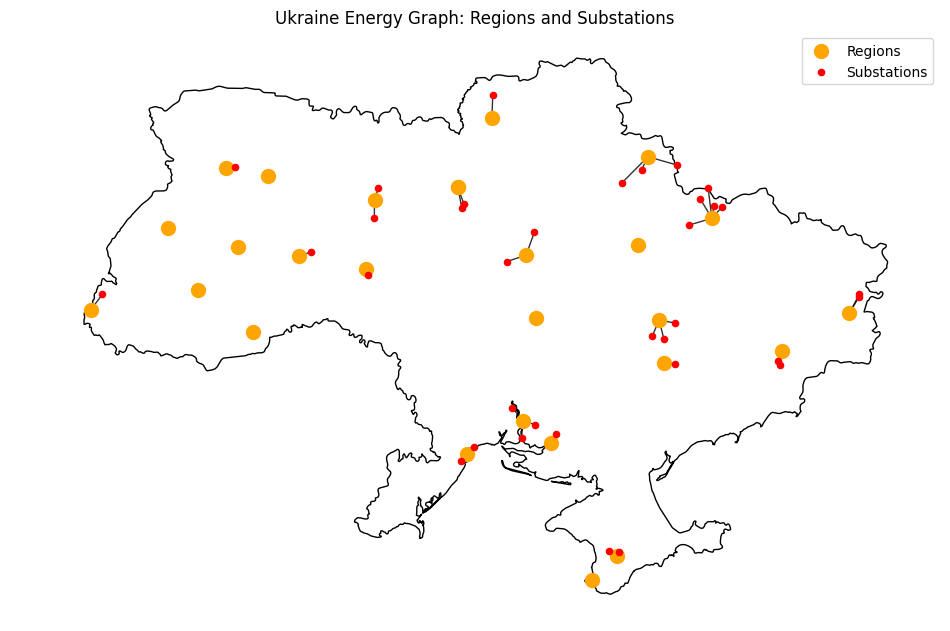

In [82]:
SHAPE_FILES = Path("shapefiles")
MAP_UKR = DATA_DIR / SHAPE_FILES / "ne_10m_admin_0_countries_ukr.shp"
# Створення графа для представлення структури енергосистеми
G = nx.Graph()

# Додаємо вузли регіонів до графа
for region in CANONICAL_REGIONS:
    G.add_node(region, node_type="region")

# Додаємо вузли підстанцій та з'єднуємо їх з відповідними регіонами
for _, row in subs_df.iterrows():
    # Створюємо унікальну назву вузла підстанції
    ps_node = f"PS_{row.substation}_{row.voltage_kv}kV"
    # Додаємо вузол підстанції з інформацією про напругу
    G.add_node(
        ps_node,
        node_type="substation",
        voltage_kv=row.voltage_kv
    )
    # Створюємо ребро між регіоном та підстанцією
    G.add_edge(row.region, ps_node, edge_type="region_substation")


# Створення словника позицій для візуалізації графа
# Беремо координати центрів регіонів, лише якщо вони присутні у списку канонічних регіонів
pos = {}

for region, (lat, lon) in REGION_COORDS.items():
    if region in CANONICAL_REGIONS:
        pos[region] = (lon, lat)  # Зберігаємо (довгота, широта) для matplotlib

# Ініціалізуємо генератор випадкових чисел з фіксованим seed для відтворюваності
rng = np.random.default_rng(42)

# Для кожної підстанції додаємо невелике випадкове зміщення,
# щоб вони не накладалися точно на центр регіону при візуалізації
for _, row in subs_df.iterrows():
    ps_node = f"PS_{row.substation}_{row.voltage_kv}kV"
    # Базові координати регіону
    base_lon, base_lat = pos[row.region]
    # Додаємо випадкове зміщення з нормальним розподілом
    dx, dy = rng.normal(0, 0.3), rng.normal(0, 0.3)
    pos[ps_node] = (base_lon + dx, base_lat + dy)


fig, ax = plt.subplots(figsize=(12, 10))

world = gpd.read_file(MAP_UKR)

# Вибираємо Україну
ukraine = world[world["NAME"] == "Ukraine"]

# ax=ax - малюємо на існуючих осях, щоб додати вузли та ребра поверх карти
ukraine.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=1
)

#Додаємо вузли регіонів
region_nodes = [n for n in G.nodes if G.nodes[n]["node_type"] == "region"]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=region_nodes,
    node_size=100,
    node_color="orange",
    ax=ax,
    label="Regions"
)

#Додаємо вузли підстанцій
ps_nodes = [n for n in G.nodes if G.nodes[n]["node_type"] == "substation"]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=ps_nodes,
    node_size=20,
    node_color="red",
    ax=ax,
    label="Substations"
)

#Додаємо ребра графа
nx.draw_networkx_edges(
    G, pos,
    alpha=0.8,
    ax=ax
)

plt.title("Ukraine Energy Graph: Regions and Substations")
plt.legend()
plt.axis("off")
plt.show()


Джерело погоди
* Open-Meteo Historical Weather API
* Базується на реаналізах ERA5 / ERA5-Land / ECMWF IFS
* Покриває період з 1940 року
* Просторова роздільна здатність ≈ 9 км
* Дані заповнюють пропуски фізично обґрунтованими моделями

| Фіча                    | Чому важливо                                         |
| ----------------------- | ---------------------------------------------------- |
| `temperature_2m_mean`   | Навантаження (обігрів / охолодження), тепловий дрейф |
| `precipitation_sum`     | Опади > КЗ, обриви, підтоплення                      |
| `snowfall_sum`          | Налипання, обриви ЛЕП                                |
| `max_wind_speed_10m`    | Основна причина аварій                               |
| `max_wind_gusts_10m`    | Пориви ламають опори                                 |
| `mean_cloud_cover`      | Непрямо: PV генерація, ізоляція                      |
| `mean_surface_pressure` | Шторми, фронти                                       |


In [83]:
# Безкоштовні HTTP-проксі (public/free proxies),
# які використовуються для обходу IP-based rate limits Open-Meteo API -_-
# брали проксі з відкритих джерел.
from fp.fp import FreeProxy

def proxy_generator():
    """Нескінченний генератор валідних HTTP/HTTPS проксі"""
    while True:
        try:
            proxy = FreeProxy(rand=True, timeout=1).get()
            yield proxy
        except Exception:
            time.sleep(1)

proxy_pool = proxy_generator()

CACHE_FILE = DATA_DIR / ".cache_openmeteo"
# ============================================================
# Open-Meteo API client factory
# ============================================================
def get_openmeteo_client(proxy=None):
    # requests_cache:
    # зберігає відповіді API локально,
    # щоб:
    # - не робити повторні запити
    # - зменшити навантаження
    # - не ловити зайві ліміти
    cache_session = requests_cache.CachedSession(CACHE_FILE, expire_after=-1)
    
    if proxy:
        cache_session.proxies = {"http": proxy, "https": proxy}
    
    retry_session = retry(cache_session, retries=3, backoff_factor=0.3)
    return openmeteo_requests.Client(session=retry_session)

# ============================================================
# Weather data fetch with proxy rotation
# ============================================================
def fetch_weather_with_retry(lats, lons, start_date, end_date, max_attempts=10):
    """Завантажує історичні погодні дані через Open-Meteo Historical Weather API.
    Це прямий API-запит до: https://archive-api.open-meteo.com"""

    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": lats,
        "longitude": lons,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_mean", "precipitation_sum", "snowfall_sum",
            "wind_speed_10m_max", "wind_gusts_10m_max", 
            "cloud_cover_mean", "surface_pressure_mean"
        ],
        "timezone": "UTC"
    }

    for attempt in range(max_attempts):
        proxy = next(proxy_pool)
        try:
            print(f"[Proxy] {proxy}")
            client = get_openmeteo_client(proxy)
            return client.weather_api(url, params=params)
        except Exception as e:
            print(f"[Fail] {proxy}: {e}")
            time.sleep(3)

    raise RuntimeError("Не вдалося отримати дані через проксі")

In [84]:
# ============================================================
# Batch download for all regions
# ============================================================
CHECKPOINT_CSV = DATA_DIR / "weather_data_checkpoint.csv"
if CHECKPOINT_CSV.exists():
    checkpoint_df = pd.read_csv(
        CHECKPOINT_CSV,
        parse_dates=["date"]
    )
else:
    checkpoint_df = pd.DataFrame(columns=["date", "region"])

def get_region_start_date(region, global_min_date):
    """Повертає дату, з якої треба догружати дані"""
    if region not in checkpoint_df["region"].values:
        return global_min_date

    last_date = (
        checkpoint_df
        .query("region == @region")["date"]
        .max()
    )

    return (last_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

weather_frames = []

# Беремо лише регіони, для яких є координати
unique_regions = [
    r for r in base_df["region"].unique()
    if r in REGION_COORDS
]

# Діапазон дат (береться з основного датасету)
global_date_max = base_df["date"].max().strftime("%Y-%m-%d")
global_date_min = base_df["date"].min().strftime("%Y-%m-%d")

BATCH_SIZE = 50

for i in range(0, len(unique_regions), BATCH_SIZE):

    batch_regions = unique_regions[i:i + BATCH_SIZE]

    lats, lons, start_dates = [], [], []

    for r in batch_regions:
        start = get_region_start_date(r, global_date_min)
        if start > global_date_max:
            continue

        lats.append(REGION_COORDS[r][0])
        lons.append(REGION_COORDS[r][1])
        start_dates.append(start)

    if not lats:
        continue

    start_date = min(start_dates)

    print(
        f"\n--- Batch {i//BATCH_SIZE + 1} | "
        f"{len(lats)} регіонів | "
        f"{start_date} → {global_date_max} ---"
    )

    responses = fetch_weather_with_retry(
        lats,
        lons,
        start_date,
        global_date_max
    )

    for j, response in enumerate(responses):
        region = batch_regions[j]
        daily = response.Daily()

        dates = pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s"),
            end=pd.to_datetime(daily.TimeEnd(), unit="s"),
            freq="D",
            inclusive="left"
        )

        wdf = pd.DataFrame({
            "date": dates.date,
            "region": region,
            "temperature_mean": daily.Variables(0).ValuesAsNumpy(),
            "precipitation": daily.Variables(1).ValuesAsNumpy(),
            "snowfall": daily.Variables(2).ValuesAsNumpy(),
            "wind_speed_max": daily.Variables(3).ValuesAsNumpy(),
            "wind_gusts_max": daily.Variables(4).ValuesAsNumpy(),
            "cloud_cover_mean": daily.Variables(5).ValuesAsNumpy(),
            "surface_pressure_mean": daily.Variables(6).ValuesAsNumpy(),
        })

        weather_frames.append(wdf)

    pd.concat(
        [checkpoint_df, *weather_frames],
        ignore_index=True
    ).drop_duplicates(
        ["date", "region"]
    ).to_csv(CHECKPOINT_CSV, index=False)

    time.sleep(2)

# ============================================================
# Final weather dataset
# ============================================================
weather_df = pd.concat([checkpoint_df, *weather_frames], ignore_index=True).drop_duplicates(["date", "region"])

print("Дані збережені.")

Дані збережені.


In [85]:
# Сортуємо дані про погоду за датою та регіоном для зручності об'єднання
weather_df = weather_df.sort_values(["date", "region"]).reset_index(drop=True)
weather_df.head()

,date,region,temperature_mean,precipitation,snowfall,wind_speed_max,wind_gusts_max,cloud_cover_mean,surface_pressure_mean
0,2022-02-24,Івано-Франківська,2.144333,0.9,0.0,21.422270,39.960000,61.791668,991.7183
1,2022-02-24,АР Крим,4.978667,3.3,0.0,28.008370,48.600000,99.958336,987.5805
2,2022-02-24,Волинська,2.568000,0.3,0.0,17.377226,30.599998,85.291664,999.9108
3,2022-02-24,Вінницька,2.574750,0.0,0.0,9.693296,21.240000,86.958336,990.0869
4,2022-02-24,Дніпропетровська,2.237417,0.0,0.0,14.345898,25.560000,66.333336,1013.5393


In [86]:
# Об'єднуємо основні дані з даними про погоду за датою та регіоном
base_df["date"] = pd.to_datetime(base_df["date"])
weather_df["date"] = pd.to_datetime(weather_df["date"])

base_df = base_df.merge(
    weather_df,
    on=["date", "region"],
    how="left"  # Зберігаємо всі рядки з base_df, додаючи погодні дані де вони є
)

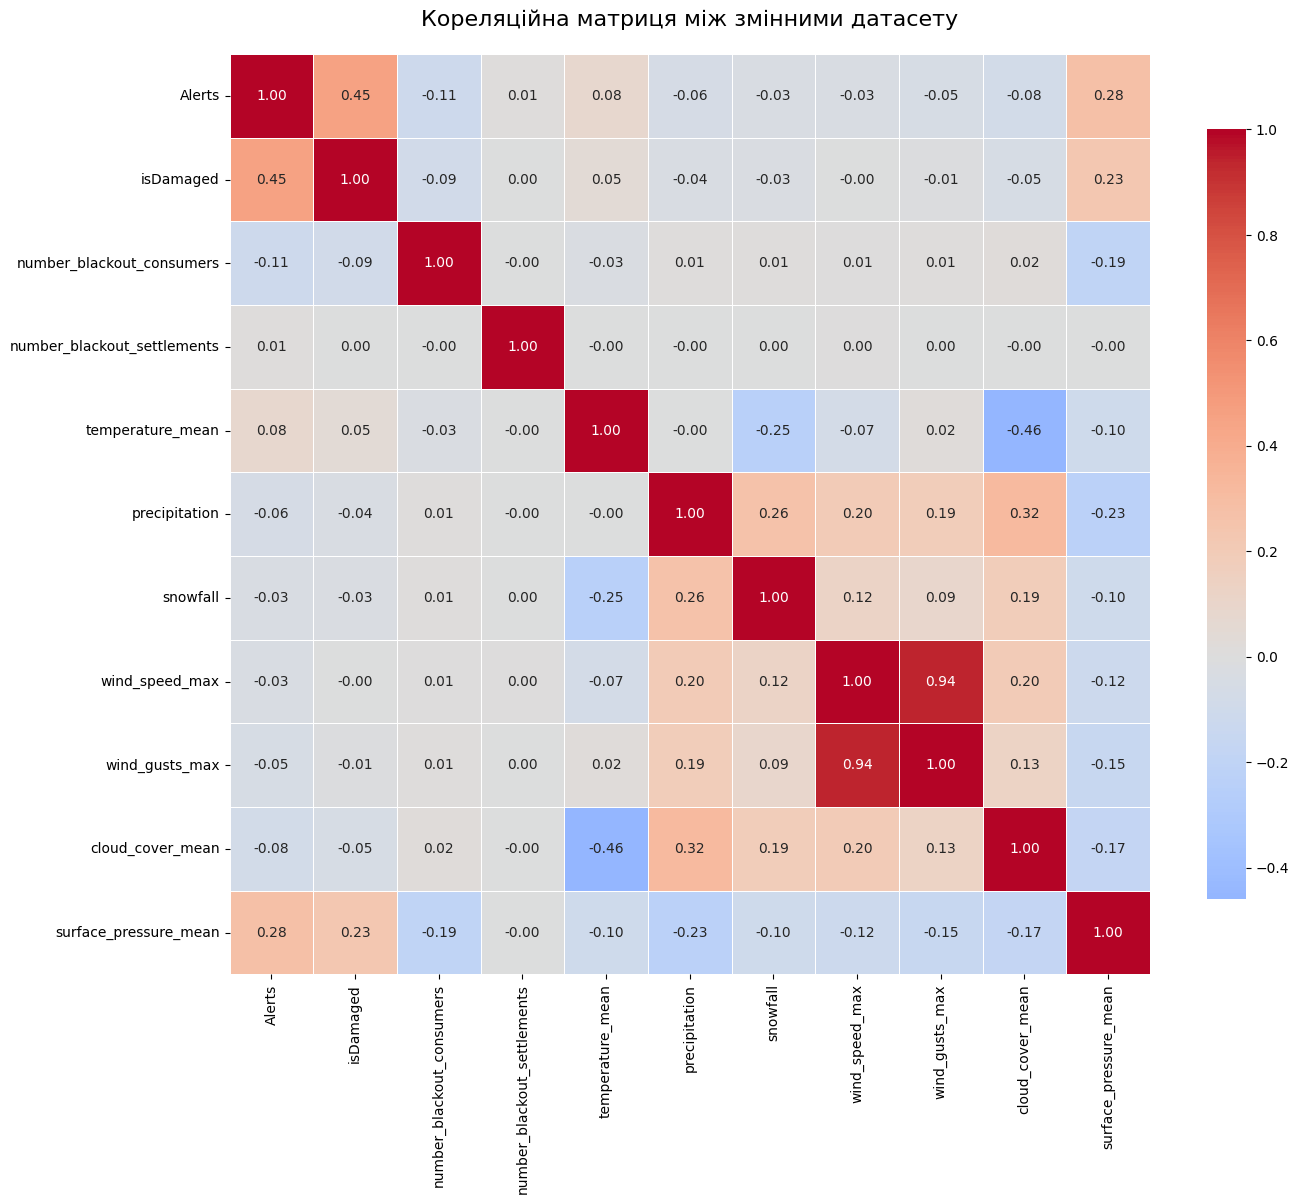


Кореляція ключових факторів з усіма іншими змінними:

Alerts:
----------------------------------------------------------------------
  isDamaged                           :  0.454 ↑
  surface_pressure_mean               :  0.280 ↑
  number_blackout_consumers           : -0.107 ↓
  temperature_mean                    :  0.081 ↑
  cloud_cover_mean                    : -0.081 ↓
  precipitation                       : -0.057 ↓
  wind_gusts_max                      : -0.046 ↓
  snowfall                            : -0.035 ↓
  wind_speed_max                      : -0.034 ↓
  number_blackout_settlements         :  0.013 ↑

isDamaged:
----------------------------------------------------------------------
  Alerts                              :  0.454 ↑
  surface_pressure_mean               :  0.235 ↑
  number_blackout_consumers           : -0.093 ↓
  cloud_cover_mean                    : -0.049 ↓
  temperature_mean                    :  0.046 ↑
  precipitation                       : -0.036 ↓

In [87]:
# ============================================================
# Кореляційний аналіз
# Аналізуємо взаємозв'язки між різними змінними в датасеті
# для розуміння залежностей та виявлення важливих факторів
# ============================================================

# ------------------------------------------------------------
# Перетворюємо isDamaged з bool → int (0/1)
# ------------------------------------------------------------
if "isDamaged" in base_df.columns:
    base_df["isDamaged"] = base_df["isDamaged"].astype(int)

# ------------------------------------------------------------
# Вибір числових змінних для кореляційного аналізу
# ------------------------------------------------------------
numeric_cols = [
    'Alerts',                          # Кількість тривог
    'isDamaged',                       # Факт пошкодження (0/1)
    'number_blackout_consumers',       # Кількість споживачів без електроенергії
    'number_blackout_settlements',     # Кількість населених пунктів без електроенергії
    'temperature_mean',                # Середня температура
    'precipitation',                   # Опади
    'snowfall',                        # Сніг
    'wind_speed_max',                  # Максимальна швидкість вітру
    'wind_gusts_max',                  # Максимальні пориви вітру
    'cloud_cover_mean',                # Середня хмарність
    'surface_pressure_mean'            # Середній приземний тиск
]

# ------------------------------------------------------------
# Створюємо датафрейм тільки з числовими змінними
# ------------------------------------------------------------
corr_df = base_df[numeric_cols].copy()

# ------------------------------------------------------------
# Обчислюємо матрицю кореляції
# ------------------------------------------------------------
correlation_matrix = corr_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title(
    'Кореляційна матриця між змінними датасету',
    fontsize=16,
    pad=20
)
plt.tight_layout()
plt.show()

# Текстова кореляція для ключових фіч
# ------------------------------------------------------------
print("\nКореляція ключових факторів з усіма іншими змінними:")

focus_features = [
    'Alerts',
    'isDamaged',
    'number_blackout_consumers',
    'number_blackout_settlements'
]

for feature in focus_features:
    if feature not in correlation_matrix.columns:
        continue

    print(f"\n{feature}:")
    print("-" * 70)

    feature_corrs = (
        correlation_matrix[feature]
        .drop(feature)
        .sort_values(key=abs, ascending=False)
    )

    for var, corr_val in feature_corrs.items():
        direction = "↑" if corr_val > 0 else "↓"
        print(f"  {var:35s} : {corr_val:6.3f} {direction}")


# ------------Training------------

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv  # Graph Attention Network для роботи з графами
from sklearn.preprocessing import StandardScaler  # Для нормалізації даних
import joblib

In [89]:
# Горизонт прогнозу (в днях, бо base_df daily). Погодинно не можна з даною вибіркою даних.
H = 1
# Довжина вікна (скільки днів бекграунду дивимося)
T_WINDOW = 7

REGION_FEATURES = [
    "Alerts",
    "isDamaged",
    "temperature_mean",
    "precipitation",
    "snowfall",
    "wind_speed_max",
    "wind_gusts_max",
    "cloud_cover_mean",
    "surface_pressure_mean",
    "log_blackout_consumers",
    "log_blackout_settlements",
]

In [90]:
# Підготовка списків регіонів та підстанцій для створення графа
REGIONS = list(CANONICAL_REGIONS)
SUBS = list(SUBSTATIONS)

# Створення структури вузлів графа
node_names = []  # Список назв вузлів
node_types = []  # Тип вузла: "region" або "substation"

# Створюємо індекси для регіонів
region_node_ids = {}
for r in REGIONS:
    region_node_ids[r] = len(node_names)
    node_names.append(f"REGION::{r}")
    node_types.append("region")

# Створюємо індекси для підстанцій
sub_node_ids = {}
for (ps_name, ps_region, kv) in SUBS:
    nid = len(node_names)
    sub_node_ids[(ps_name, ps_region, kv)] = nid
    node_names.append(f"PS::{ps_name}::{ps_region}::{kv}")
    node_types.append("substation")

N_NODES = len(node_names)

print("Nodes:", N_NODES)
print("Regions:", len(REGIONS))
print("Substations:", len(SUBS))


Nodes: 62
Regions: 27
Substations: 35


In [91]:
# Функція для обчислення відстані між двома точками на Землі (формула гаверсинус)
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Обчислює відстань між двома точками на поверхні Землі в кілометрах.
    Використовує формулу гаверсинус для сферичної геометрії.
    """
    R = 6371.0  # Радіус Землі в кілометрах
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dl = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dl/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

# Кількість найближчих сусідів для кожного регіону
K_NEIGHBORS = 4

# Створюємо словник координат регіонів та перевіряємо наявність
region_coords = {}
missing = []
for r in REGIONS:
    if r not in REGION_COORDS:
        missing.append(r)
    else:
        region_coords[r] = REGION_COORDS[r]
if missing:
    print("WARNING: Missing coords for:", missing)

# Створюємо ребра між регіонами на основі географічної близькості
region_edges = []
for r1 in REGIONS:
    if r1 not in region_coords:
        continue
    lat1, lon1 = region_coords[r1]
    dists = []
    # Обчислюємо відстані до всіх інших регіонів
    for r2 in REGIONS:
        if r2 == r1 or r2 not in region_coords:
            continue
        lat2, lon2 = region_coords[r2]
        d = haversine_km(lat1, lon1, lat2, lon2)
        dists.append((d, r2))
    # Сортуємо за відстанню та вибираємо K найближчих сусідів
    dists.sort(key=lambda x: x[0])
    for _, r2 in dists[:K_NEIGHBORS]:
        a = region_node_ids[r1]
        b = region_node_ids[r2]
        # Додаємо обидва напрямки (неорієнтований граф)
        region_edges.append((a, b))
        region_edges.append((b, a))

# Створюємо ребра між регіонами та підстанціями
sub_edges = []
for (ps_name, ps_region, kv) in SUBS:
    if ps_region not in region_node_ids:
        continue
    r_id = region_node_ids[ps_region]
    ps_id = sub_node_ids[(ps_name, ps_region, kv)]
    # Додаємо обидва напрямки зв'язку
    sub_edges.append((r_id, ps_id))
    sub_edges.append((ps_id, r_id))

# Об'єднуємо всі ребра та конвертуємо в формат PyTorch Geometric
edges = region_edges + sub_edges
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print("Edges:", edge_index.shape[1])


Edges: 286


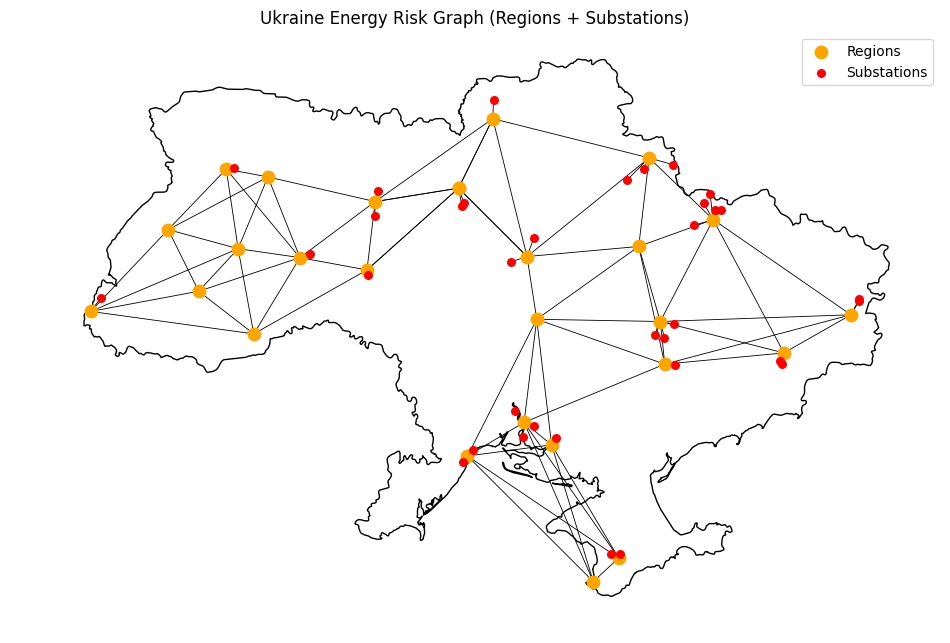

Total nodes: 62
Total edges: 105
Sample substation edges: [('REGION::Вінницька', 'PS::Вінницька::Вінницька::750'), ('REGION::Волинська', 'PS::Луцьк-Північна::Волинська::330'), ('REGION::Дніпропетровська', 'PS::Південна::Дніпропетровська::330'), ('REGION::Дніпропетровська', 'PS::Пічна::Дніпропетровська::330'), ('REGION::Дніпропетровська', 'PS::Криворізька::Дніпропетровська::330'), ('REGION::Донецька', 'PS::Донбаська::Донецька::330'), ('REGION::Донецька', 'PS::Центральна::Донецька::110'), ('REGION::Житомирська', 'PS::Західноукраїнська::Житомирська::750'), ('REGION::Житомирська', 'PS::Лісова::Житомирська::330'), ('REGION::Закарпатська', 'PS::Мукачево::Закарпатська::440')]


In [92]:
G = nx.Graph()

for r in REGIONS:
    if r not in REGION_COORDS:
        continue
    G.add_node(
        f"REGION::{r}",
        node_type="region",
        region=r
    )

for (ps_name, ps_region, kv) in SUBS:
    if ps_region not in REGION_COORDS:
        continue
    ps_node = f"PS::{ps_name}::{ps_region}::{kv}"
    G.add_node(
        ps_node,
        node_type="substation",
        region=ps_region,
        kv=kv
    )

for a, b in region_edges:
    r1 = REGIONS[a]
    r2 = REGIONS[b]

    n1 = f"REGION::{r1}"
    n2 = f"REGION::{r2}"

    if n1 not in G:
        G.add_node(n1, node_type="region", region=r1)
    if n2 not in G:
        G.add_node(n2, node_type="region", region=r2)

    G.add_edge(n1, n2)

for (ps_name, ps_region, kv) in SUBS:
    region_node = f"REGION::{ps_region}"
    ps_node = f"PS::{ps_name}::{ps_region}::{kv}"

    if region_node in G and ps_node in G:
        G.add_edge(region_node, ps_node)

pos = {}

for r, (lat, lon) in REGION_COORDS.items():
    pos[f"REGION::{r}"] = (lon, lat)

rng = np.random.default_rng(42)
for (ps_name, ps_region, kv) in SUBS:
    if ps_region not in REGION_COORDS:
        continue
    lat, lon = REGION_COORDS[ps_region]

    ps_node = f"PS::{ps_name}::{ps_region}::{kv}"
    pos[ps_node] = (
        lon + rng.normal(0, 0.25),
        lat + rng.normal(0, 0.25)
    )

fig, ax = plt.subplots(figsize=(12, 10))

world = gpd.read_file(MAP_UKR)
ukraine = world[world["NAME"] == "Ukraine"]

ukraine.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=1
)

region_nodes = [
    n for n in G.nodes
    if G.nodes[n].get("node_type") == "region"
]

ps_nodes = [
    n for n in G.nodes
    if G.nodes[n].get("node_type") == "substation"
]

nx.draw_networkx_nodes(
    G, pos,
    nodelist=region_nodes,
    node_size=80,
    node_color="orange",
    ax=ax,
    label="Regions"
)

nx.draw_networkx_nodes(
    G, pos,
    nodelist=ps_nodes,
    node_size=30,
    node_color="red",
    ax=ax,
    label="Substations"
)

nx.draw_networkx_edges(
    G, pos,
    alpha=1,
    width=0.6,
    ax=ax
)

plt.title("Ukraine Energy Risk Graph (Regions + Substations)")
plt.legend()
plt.axis("off")
plt.show()

print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

substation_edges = [
    (u, v) for (u, v) in G.edges
    if u.startswith("PS::") or v.startswith("PS::")
]

print("Sample substation edges:", substation_edges[:10])


In [93]:
# Підготовка датафрейму для навчання моделі
df = base_df.copy()

# Уніфікуємо типи даних для консистентності
df["date"] = pd.to_datetime(df["date"]).dt.date
df["region"] = df["region"].astype(str)

# Створюємо повний індекс для всіх комбінацій дат та регіонів
dates = sorted(df["date"].unique())
full_index = pd.MultiIndex.from_product([dates, REGIONS], names=["date", "region"])

# Якщо в df є дублікати (date, region) - агрегуємо їх (беремо перше значення)
agg_map = {c: "first" for c in df.columns if c not in ["date", "region"]}
df_agg = df.groupby(["date", "region"], as_index=False).agg(agg_map)

# Розширюємо до повного індексу (заповнюємо пропуски)
df_full = (
    df_agg.set_index(["date", "region"])
          .reindex(full_index)
          .reset_index()
)

# Заповнюємо пропуски для категоріальних та булевих змінних
df_full["Alerts"] = df_full["Alerts"].fillna(0).astype(int)
df_full["isDamaged"] = df_full["isDamaged"].fillna(False).astype(bool)

# Заповнюємо пропуски для числових змінних нулями
for col in ["temperature_mean", "precipitation", "snowfall", "wind_speed_max", "wind_gusts_max",
            "cloud_cover_mean", "surface_pressure_mean",
            "log_blackout_consumers", "log_blackout_settlements",
            "number_blackout_consumers", "number_blackout_settlements"]:
    if col in df_full.columns:
        df_full[col] = df_full[col].fillna(0)


df_full = df_full.sort_values(["date", "region"]).reset_index(drop=True)

In [94]:
# Створення словників для маппінгу дат та регіонів до індексів
time_to_idx = {d:i for i,d in enumerate(dates)}
region_to_idx = {r:i for i,r in enumerate(REGIONS)}

R = len(REGIONS)  # Кількість регіонів
T = len(dates)    # Кількість днів

# Функція для перетворення колонки датафрейму в 2D матрицю [час, регіон]
def pivot_2d(col):
    """
    Перетворює колонку датафрейму в матрицю розміру (T, R),
    де T - кількість днів, R - кількість регіонів.
    """
    mat = np.zeros((T, R), dtype=np.float32)
    for i, d in enumerate(dates):
        chunk = df_full[df_full["date"] == d]
        for _, row in chunk.iterrows():
            mat[i, region_to_idx[row["region"]]] = float(row.get(col, 0))
    return mat

# Створюємо матриці для різних ознак
blackout_cons = pivot_2d("number_blackout_consumers")
alerts_mat    = pivot_2d("Alerts")
damaged_mat   = pivot_2d("isDamaged")
damaged_mat   = (damaged_mat > 0).astype(np.float32)

# Створюємо цільову змінну y_region: чи буде потрібна дія через H днів
# Дія потрібна, якщо є відключення, тривоги або пошкодження
y_region = np.zeros((T, R), dtype=np.float32)
for t in range(T):
    t2 = t + H  # Час через H днів
    if t2 >= T:
        continue  # Якщо виходимо за межі даних, пропускаємо
    # Дія потрібна, якщо хоча б одна з умов виконується
    y_region[t] = ((blackout_cons[t2] > 0) | (alerts_mat[t2] > 0) | (damaged_mat[t2] > 0)).astype(np.float32)

print("y_region shape:", y_region.shape)


y_region shape: (1274, 27)


In [95]:
# Визначаємо всі ознаки, включаючи нормалізовану напругу для підстанцій
ALL_FEATURES = REGION_FEATURES + ["kv_norm"]
F_DIM = len(ALL_FEATURES)  # Розмірність вектора ознак

# Функція для нормалізації напруги підстанцій (110-750 кВ)
def kv_to_norm(kv):
    """Нормалізує напругу підстанції до діапазону [0, 1]"""
    return (kv - 110.0) / (750.0 - 110.0 + 1e-9)

# Створюємо індексований датафрейм для швидкого доступу
df_full_keyed = df_full.set_index(["date", "region"])

# Створюємо тензор ознак: [час, вузол, ознака]
X = np.zeros((T, N_NODES, F_DIM), dtype=np.float32)

for ti, d in enumerate(dates):
    # --- Обробка регіонів ---
    for r in REGIONS:
        rid = region_node_ids[r]
        row = df_full_keyed.loc[(d, r)]

        # Формуємо вектор ознак для регіону
        feats = []
        for c in REGION_FEATURES:
            if c == "isDamaged":
                feats.append(float(bool(row[c])))  # Конвертуємо булеву змінну
            else:
                feats.append(float(row[c]))
        feats.append(0.0)  # kv_norm для регіону завжди 0
        X[ti, rid, :] = np.array(feats, dtype=np.float32)

    # --- Обробка підстанцій ---
    for (ps_name, ps_region, kv) in SUBS:
        if ps_region not in region_node_ids:
            continue
        psid = sub_node_ids[(ps_name, ps_region, kv)]
        # Динамічні ознаки підстанції беремо з регіону, де вона розташована
        row = df_full_keyed.loc[(d, ps_region)]

        feats = []
        for c in REGION_FEATURES:
            if c == "isDamaged":
                feats.append(float(bool(row[c])))
            else:
                feats.append(float(row[c]))
        feats.append(float(kv_to_norm(kv)))  # Додаємо нормалізовану напругу
        X[ti, psid, :] = np.array(feats, dtype=np.float32)

print("X:", X.shape)


X: (1274, 62, 12)


In [96]:
# Розділення даних на навчальну та валідаційну вибірки (80/20)
split_idx = int(0.8 * T)

train_times = np.arange(0, split_idx)  # Індекси для навчальної вибірки
val_times   = np.arange(split_idx, T)  # Індекси для валідаційної вибірки

# Створюємо стандартизатор для нормалізації ознак
scaler = StandardScaler()

# Навчаємо стандартизатор тільки на навчальних даних
X_train_flat = X[train_times].reshape(-1, F_DIM)  # Перетворюємо (time, node) -> (samples, features)
scaler.fit(X_train_flat)

# Застосовуємо стандартизацію до всіх даних
X_scaled = X.copy()
X_scaled = scaler.transform(X_scaled.reshape(-1, F_DIM)).reshape(T, N_NODES, F_DIM)

print("Scaled X ok:", X_scaled.shape)


Scaled X ok: (1274, 62, 12)


In [97]:
# Створюємо матрицю цільових змінних для всіх вузлів (регіони + підстанції)
Y = np.zeros((T, N_NODES), dtype=np.float32)

for ti, d in enumerate(dates):
    # Призначаємо цільові значення для регіонів
    for r in REGIONS:
        rid = region_node_ids[r]
        Y[ti, rid] = y_region[ti, region_to_idx[r]]

    # Призначаємо цільові значення для підстанцій (беремо з регіону)
    for (ps_name, ps_region, kv) in SUBS:
        if ps_region not in region_to_idx:
            continue
        psid = sub_node_ids[(ps_name, ps_region, kv)]
        Y[ti, psid] = y_region[ti, region_to_idx[ps_region]]

# Функція для створення послідовностей даних для навчання
def build_samples(time_indices):
    """
    Створює зразки для навчання з вікном T_WINDOW.
    Кожен зразок містить послідовність ознак за T_WINDOW днів та цільове значення.
    """
    samples = []
    for t_last in time_indices:
        # Перевіряємо, чи достатньо даних для вікна
        if t_last < T_WINDOW - 1:
            continue
        # Перевіряємо, чи не виходимо за межі при прогнозі
        if t_last + H >= T:
            continue
        # Визначаємо початок вікна
        t0 = t_last - (T_WINDOW - 1)
        X_seq = X_scaled[t0:t_last+1]  # Послідовність ознак за T_WINDOW днів
        y = Y[t_last]  # Цільове значення на момент t_last
        samples.append((X_seq, y))
    return samples

# Створюємо навчальну та валідаційну вибірки
train_samples = build_samples(train_times)
val_samples   = build_samples(val_times)

print("Train samples:", len(train_samples))
print("Val samples:", len(val_samples))


Train samples: 1013
Val samples: 254


In [98]:
class TemporalGAT(nn.Module):
    def __init__(self, in_dim, gat_hidden=64, gat_heads=4, gru_hidden=64, mlp_hidden=64):
        super().__init__()
        self.gat1 = GATConv(in_dim, gat_hidden, heads=gat_heads, concat=True, dropout=0.1)
        self.gat2 = GATConv(gat_hidden*gat_heads, gat_hidden, heads=1, concat=False, dropout=0.1)

        self.gru = nn.GRU(input_size=gat_hidden, hidden_size=gru_hidden, batch_first=False)

        self.mlp = nn.Sequential(
            nn.Linear(gru_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, 1)
        )

    def forward(self, x_seq, edge_index):
        """
        x_seq: [T_WINDOW, N, F]
        returns logits: [N]
        """
        T_w, N, Fdim = x_seq.shape
        embeds = []

        for t in range(T_w):
            x = x_seq[t]  # [N, F]
            h = self.gat1(x, edge_index)
            h = F.elu(h)
            h = self.gat2(h, edge_index)
            h = F.elu(h)
            embeds.append(h)  # [N, gat_hidden]

        H_seq = torch.stack(embeds, dim=0) # [T_WINDOW, N, gat_hidden]
        out, _ = self.gru(H_seq) # [T_WINDOW, N, gru_hidden]
        h_last = out[-1] # [N, gru_hidden]

        logits = self.mlp(h_last).squeeze(-1)  # [N]
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalGAT(in_dim=F_DIM).to(device)
edge_index_t = edge_index.to(device)

print(model)
print("Device:", device)


TemporalGAT(
  (gat1): GATConv(12, 64, heads=4)
  (gat2): GATConv(256, 64, heads=1)
  (gru): GRU(64, 64)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Device: cpu


In [99]:
# Чи запускати навчання нейронної мережі
# runNN = True
runNN = False

In [100]:
if runNN:
    from sklearn.metrics import roc_auc_score

    def batch_to_torch(sample):
        X_seq, y = sample
        X_seq = torch.tensor(X_seq, dtype=torch.float32, device=device)
        y = torch.tensor(y, dtype=torch.float32, device=device)
        return X_seq, y

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    @torch.no_grad()
    def eval_roc_auc(samples):
        model.eval()

        y_true_all = []
        y_pred_all = []

        for s in samples:
            X_seq, y = batch_to_torch(s)
            logits = model(X_seq, edge_index_t)
            probs = torch.sigmoid(logits)

            y_true_all.append(y.detach().cpu().numpy())
            y_pred_all.append(probs.detach().cpu().numpy())

        if not y_true_all:
            return np.nan

        y_true_all = np.concatenate(y_true_all)
        y_pred_all = np.concatenate(y_pred_all)

        if len(np.unique(y_true_all)) < 2:
            return np.nan

        return roc_auc_score(y_true_all, y_pred_all)

    @torch.no_grad()
    def eval_loss(samples):
        model.eval()
        losses = []
        for s in samples:
            X_seq, y = batch_to_torch(s)
            logits = model(X_seq, edge_index_t)
            loss = criterion(logits, y)
            losses.append(loss.item())
        return float(np.mean(losses)) if losses else np.nan

    def train_epoch(samples):
        model.train()
        losses = []
        for s in samples:
            X_seq, y = batch_to_torch(s)
            optimizer.zero_grad()
            logits = model(X_seq, edge_index_t)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return float(np.mean(losses)) if losses else np.nan

    EPOCHS = 20
    for ep in range(1, EPOCHS+1):
        tr = train_epoch(train_samples)
        va = eval_loss(val_samples)
        roc = eval_roc_auc(val_samples)
        print(f"Epoch {ep:02d} | train={tr:.4f} | val={va:.4f}, ROC AUC={roc:.4f}")


In [101]:
if runNN:
    SERIALIZED_DIR = Path('serialized')
    os.makedirs(SERIALIZED_DIR, exist_ok=True)
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "edge_index": edge_index_t.cpu(),
            "node_names": node_names,
            "node_types": node_types,
        },
        Path.joinpath(SERIALIZED_DIR, "risk_gnn_model.pt")
    )

    # збереження scaler
    joblib.dump(scaler, Path.joinpath(SERIALIZED_DIR, "risk_gnn_scaler.pkl"))
    print("Saved:")
    print(" - risk_gnn_model.pt")
    print(" - risk_gnn_scaler.pkl")


In [102]:
base_df.tail()

,date,region,number_blackout_consumers,number_blackout_settlements,Alerts,isDamaged,log_blackout_consumers,log_blackout_settlements,alert_intensity,temperature_mean,precipitation,snowfall,wind_speed_max,wind_gusts_max,cloud_cover_mean,surface_pressure_mean
34393,2025-10-12,Хмельницька,0,0,0,0,0.000000,0.000000,0,10.952334,1.4,0.0,25.051706,45.360000,90.250000,983.32635
34394,2025-10-12,Черкаська,50,72,5,1,3.931826,4.290459,10,10.992748,0.2,0.0,21.993908,42.839996,69.916664,1000.84980
34395,2025-10-12,Чернівецька,0,0,0,0,0.000000,0.000000,0,11.921000,1.0,0.0,20.327251,41.399998,89.875000,991.14185
34396,2025-10-12,Чернігівська,1797,32,15,1,7.494430,3.496508,30,9.999667,1.9,0.0,28.623962,56.880000,84.958336,995.14210
34397,2025-10-12,м. Севастополь,0,0,0,0,0.000000,0.000000,0,12.232417,1.1,0.0,14.871530,33.120000,60.833332,1015.96564


In [103]:
if runNN:
    @torch.no_grad()
    def predict_for_time(t_last):
        model.eval()
        t0 = t_last - (T_WINDOW - 1)
        X_seq = X_scaled[t0:t_last+1]
        X_seq = torch.tensor(X_seq, dtype=torch.float32, device=device)
        logits = model(X_seq, edge_index_t)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        return probs

    t_last = T - H - 1
    probs = predict_for_time(t_last)

    rows = []
    for nid, p in enumerate(probs):
        rows.append({
            "node": node_names[nid],
            "node_type": node_types[nid],
            "p_need_action": float(p),
        })

    pred_df = pd.DataFrame(rows).sort_values("p_need_action", ascending=False)
    print(pred_df.tail(20))


In [104]:
if not runNN:
    import joblib
    import torch
    import pandas as pd

    # =========================
    # LOAD MODEL & ARTIFACTS
    # =========================
    checkpoint = torch.load(Path.joinpath(SERIALIZED_DIR, "risk_gnn_model.pt"), map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    edge_index_t = checkpoint["edge_index"].to(device)
    node_names = checkpoint["node_names"]
    node_types = checkpoint["node_types"]

    scaler = joblib.load(Path.joinpath(SERIALIZED_DIR, "risk_gnn_scaler.pkl"))

    print("Loaded:")
    print(" - risk_gnn_model.pt")
    print(" - risk_gnn_scaler.pkl")

    # =========================
    # INFERENCE FUNCTION
    # =========================
    @torch.no_grad()
    def predict_for_time(t_last):
        model.eval()

        t0 = t_last - (T_WINDOW - 1)

        # (T_window, N_nodes, N_features)
        X_seq = X[t0:t_last + 1]

        T_w, N, F = X_seq.shape

        # --------- SCALE FEATURES CORRECTLY ----------
        # (T, N, F) -> (T*N, F)
        X_flat = X_seq.reshape(-1, F)

        X_flat = scaler.transform(X_flat)

        # (T*N, F) -> (T, N, F)
        X_seq = X_flat.reshape(T_w, N, F)
        # --------------------------------------------

        X_seq = torch.tensor(
            X_seq,
            dtype=torch.float32,
            device=device
        )

        logits = model(X_seq, edge_index_t)
        probs = torch.sigmoid(logits).cpu().numpy()

        return probs

    # =========================
    # RUN INFERENCE
    # =========================
    t_last = T - H - 1
    probs = predict_for_time(t_last)

    # =========================
    # FORMAT OUTPUT
    # =========================
    rows = []
    for nid, p in enumerate(probs):
        rows.append({
            "node": node_names[nid],
            "node_type": node_types[nid],
            "p_need_action": float(p),
        })

    pred_df = (
        pd.DataFrame(rows)
        .sort_values("p_need_action", ascending=False)
    )

    print(pred_df.tail(20))


Loaded:
 - risk_gnn_model.pt
 - risk_gnn_scaler.pkl
                                       node   node_type  p_need_action
0                         REGION::Вінницька      region       0.614346
30            PS::Вінницька::Вінницька::750  substation       0.565547
24                             REGION::Київ      region       0.560902
4                       REGION::Житомирська      region       0.554121
31  PS::Західноукраїнська::Житомирська::750  substation       0.482324
52             PS::Лісова::Житомирська::330  substation       0.431705
15                       REGION::Рівненська      region       0.426136
20                      REGION::Хмельницька      region       0.409971
50        PS::Хмельницька::Хмельницька::330  substation       0.398405
17                    REGION::Тернопільська      region       0.377462
7                 REGION::Івано-Франківська      region       0.375601
22                      REGION::Чернівецька      region       0.369621
32          PS::Мукачево:

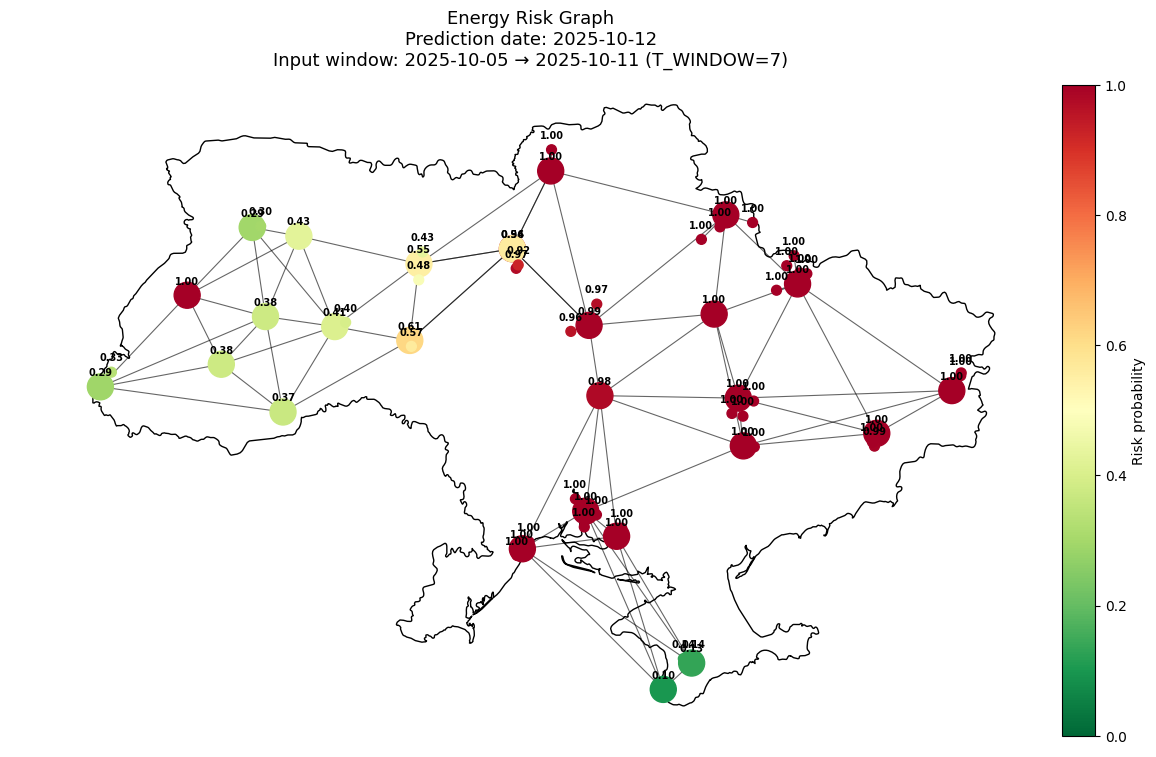

In [106]:
import matplotlib.colors as mcolors

def risk_to_color(p):
    """
    0.0 -> green
    0.5 -> yellow
    1.0 -> red
    """
    cmap = plt.cm.RdYlGn_r
    return cmap(p)

fig, ax = plt.subplots(figsize=(14, 12))

# --- базова карта України ---
import geopandas as gpd
world = gpd.read_file(MAP_UKR)
ukraine = world[world["NAME"] == "Ukraine"]
ukraine.plot(ax=ax, color="white", edgecolor="black", linewidth=1)

node_colors = [risk_to_color(p) for p in probs]
node_sizes = [
    350 if t == "region" else 50
    for t in node_types
]

nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    alpha=0.6,
    width=0.8
)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    ax=ax
)

for nid, node in enumerate(node_names):
    x, y = pos[node]
    ax.text(
        x,
        y + 0.12,
        f"{probs[nid]:.2f}",
        fontsize=7,
        ha="center",
        va="bottom",
        color="black",
        weight="bold"
    )

# --- заголовок ---
date_pred = dates[t_last + H]
date_from = dates[t_last - T_WINDOW + 1]
date_to   = dates[t_last]

ax.set_title(
    f"Energy Risk Graph\n"
    f"Prediction date: {date_pred}\n"
    f"Input window: {date_from} → {date_to} (T_WINDOW={T_WINDOW})",
    fontsize=13
)

ax.axis("off")

# --- colorbar ---
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.RdYlGn_r,
    norm=mcolors.Normalize(vmin=0, vmax=1)
)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Risk probability", fontsize=10)

plt.show()


In [107]:
print("Total dates:", len(dates))
print("First date:", dates[0])
print("Last date:", dates[-1])

print("Last possible t_last index:", T - H - 1)
print("Prediction date:", dates[T - 1])

Total dates: 1274
First date: 2022-02-24
Last date: 2025-10-12
Last possible t_last index: 1272
Prediction date: 2025-10-12


In [108]:
@torch.no_grad()
def predict_from_single_day(day_features_scaled):
    """
    day_features_scaled: (N_NODES, F_DIM)
    """
    X_seq = np.repeat(
        day_features_scaled[np.newaxis, :, :],
        T_WINDOW,
        axis=0
    )

    X_seq = torch.tensor(
        X_seq,
        dtype=torch.float32,
        device=device
    )

    logits = model(X_seq, edge_index_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs

WHAT_IF_CHANGES = [
    {
        "region": "Київ",
        "feature": "temperature_mean",
        "operation": "add",
        "value": +5.0,
        "description": "Heat wave in Kyiv"
    },
    {
        "region": "Київ",
        "feature": "wind_gusts_max",
        "operation": "mul",
        "value": 1.6,
        "description": "Wind gusts in Kyiv"
    }
]

def apply_what_if(base_day, changes):
    modified = base_day.copy()
    logs = []

    for ch in changes:
        region = ch["region"]
        feature = ch["feature"]
        op = ch["operation"]
        val = ch["value"]

        f_idx = ALL_FEATURES.index(feature)

        for nid, node in enumerate(node_names):
            if region not in node:
                continue

            before = modified[nid, f_idx]

            if op == "mul":
                after = before * val
            elif op == "add":
                after = before + val
            else:
                raise ValueError("Unknown operation")

            modified[nid, f_idx] = after

            logs.append({
                "node": node,
                "node_type": node_types[nid],
                "region": region,
                "feature": feature,
                "before": float(before),
                "after": float(after),
                "operation": op,
                "value": val,
                "delta_input": float(after - before),
                "description": ch["description"]
            })

    return modified, pd.DataFrame(logs)

# ===== BASE =====
base_day = X_scaled[-1]
probs_base = predict_from_single_day(base_day)

# ===== WHAT-IF =====
custom_day, change_log = apply_what_if(base_day, WHAT_IF_CHANGES)
probs_modified = predict_from_single_day(custom_day)

delta_risk = probs_modified - probs_base

impact_df = pd.DataFrame({
    "node": node_names,
    "node_type": node_types,
    "risk_base": probs_base,
    "risk_modified": probs_modified,
    "risk_delta": delta_risk,
})

print("\n=== WHAT-IF INPUT CHANGES FOR KYIV ===\n")

display(
    change_log[
        change_log["region"] == "Київ"
    ][[
        "node",
        "node_type",
        "feature",
        "before",
        "after",
        "operation",
        "value",
        "description"
    ]]
)

print("\n=== RISK IMPACT FOR KYIV ===\n")

display(
    impact_df[
        impact_df["node"].str.contains("Київ")
    ][[
        "node",
        "node_type",
        "risk_base",
        "risk_modified",
        "risk_delta"
    ]]
    .sort_values("risk_delta", ascending=False)
)

print("\n=== EXPLANATION ===\n")

for ch in WHAT_IF_CHANGES:
    print(
        f"For region '{ch['region']}' we applied: "
        f"{ch['feature']} "
        f"{'×' if ch['operation']=='mul' else '+'}{ch['value']} "
        f"→ {ch['description']}"
    )

top = impact_df[impact_df["node"].str.contains("Київ")].sort_values(
    "risk_delta", ascending=False
).head(3)

print("\nMost affected Kyiv nodes:")
for _, r in top.iterrows():
    print(
        f"- {r['node']} ({r['node_type']}): "
        f"Δrisk = {r['risk_delta']:+.3f}"
    )



=== WHAT-IF INPUT CHANGES FOR KYIV ===



,node,node_type,feature,before,after,operation,value,description
0,REGION::Київська,region,temperature_mean,-0.079894,4.920106,add,5.0,Heat wave in Kyiv
1,REGION::Київ,region,temperature_mean,-0.079894,4.920106,add,5.0,Heat wave in Kyiv
2,PS::Київська::Київська::750,substation,temperature_mean,-0.079894,4.920106,add,5.0,Heat wave in Kyiv
3,PS::Новокиївська::Київська::330,substation,temperature_mean,-0.079894,4.920106,add,5.0,Heat wave in Kyiv
4,REGION::Київська,region,wind_gusts_max,1.059511,1.695217,mul,1.6,Wind gusts in Kyiv
5,REGION::Київ,region,wind_gusts_max,1.059511,1.695217,mul,1.6,Wind gusts in Kyiv
6,PS::Київська::Київська::750,substation,wind_gusts_max,1.059511,1.695217,mul,1.6,Wind gusts in Kyiv
7,PS::Новокиївська::Київська::330,substation,wind_gusts_max,1.059511,1.695217,mul,1.6,Wind gusts in Kyiv



=== RISK IMPACT FOR KYIV ===



,node,node_type,risk_base,risk_modified,risk_delta
34,PS::Новокиївська::Київська::330,substation,0.782544,0.995225,0.212681
8,REGION::Київська,region,0.782890,0.995218,0.212328
27,PS::Київська::Київська::750,substation,0.831788,0.989352,0.157565
24,REGION::Київ,region,0.310191,0.108769,-0.201422



=== EXPLANATION ===

For region 'Київ' we applied: temperature_mean +5.0 → Heat wave in Kyiv
For region 'Київ' we applied: wind_gusts_max ×1.6 → Wind gusts in Kyiv

Most affected Kyiv nodes:
- PS::Новокиївська::Київська::330 (substation): Δrisk = +0.213
- REGION::Київська (region): Δrisk = +0.212
- PS::Київська::Київська::750 (substation): Δrisk = +0.158
